Michał Szczurek Informatyka II rok, grupa wtorek 12:50 B

# 1. Narzędzie graficzne

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# 2. Biblioteki

In [4]:
import math
import random
import time
random.seed(1234) # wybranie ziarna

# 3. Funkcje generujące zbiory danych

In [5]:
def create_a (n , left, right):
    res = [(random.uniform(left, right),random.uniform(left, right)) for i in range(n)]
    return res

In [6]:
def create_b (n, center, r):
    res =[None for i in range(n)]
    for i in range(n):
        theta = random.uniform(0, 2*math.pi)
        x = r * math.cos(theta) + center[0]
        y = r * math.sin(theta) + center[1]
        res[i] = (x, y)
    return res

In [7]:
def create_c (n, upl, botl, botr, upr):
    res = []
    a = upr[0] - upl[0] 
    b = upl[1] - botl[1]
    perimeter = 2 * a + 2 * b
    for i in range(n):
        side = random.uniform(0, perimeter)
        if 0 <= side < a:
            x = random.uniform(upl[0], upr[0])
            res.append((x,upl[1]))
        elif a <= side < 2*a:
            x = random.uniform(upl[0], upr[0])
            res.append((x,botl[1]))
        elif 2*a <= side < 2*a + b:
            y = random.uniform(botr[1], upr[1])
            res.append((upl[0],y))
        else: 
            y = random.uniform(botr[1], upr[1])
            res.append((upr[0],y))
    return res

In [8]:
def create_d(botl, botr, upr, upl, n1, n2):
    res = []
    a = upr[0] - upl[0]
    for i in range (n2):
        s = random.randint(0,1)
        d = random.uniform(0,a)
        if s == 0:   
            p = (botl[0]+d,botl[1]+d)
            res.append(p)
        else:
            p = (botl[0]+d,upl[1]-d)        
            res.append(p)
    for i in range(n1):
        side = random.randint(0,1)
        if side == 0:
            x = random.uniform(upl[0], upr[0])
            res.append((x, botl[1]))
        else:
            y = random.uniform(botr[1], upr[1])
            res.append((upl[0],y))         
   
    res += [botl, botr, upr, upl]  
    random.shuffle(res)  # funkcja zmienia kolejność punktów w liście- zapobiega to sytuacji, gdy 1 połowa listy zawiera punkty
    # z przekątnych, a 2 z boków- dane są bardziej rzeczywiste.
    return res

In [64]:
# Uwaga: kolejność wierzchołków (np: prawy dolny, lewy górny...) jest istotna i powinna byc taka jak w przykładowych wywołaniach.
tab1 = create_a(100, -100, 100)
tab2 = create_b(100, (0,0), 10)
tab3 = create_c(100, (-10,10), (-10,-10), (10,-10), (10, 10))
tab4 = create_d( (0,0), (10,0), (10,10), (0,10), 25, 20)  

# 4. Wizualizacja ziobrów danych

<IPython.core.display.Javascript object>


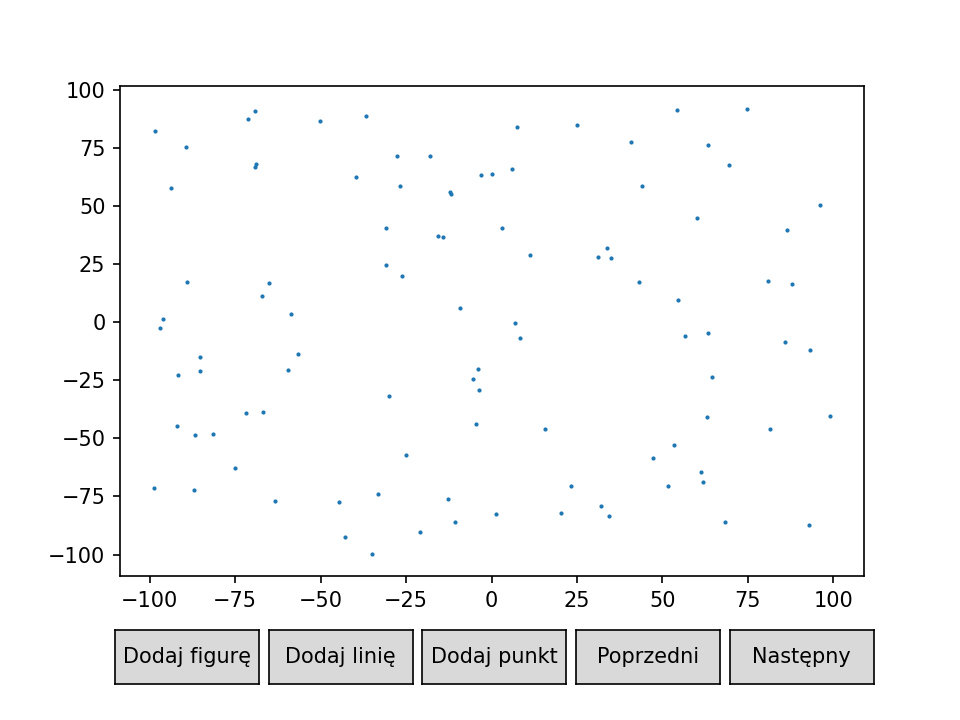

In [10]:
%matplotlib notebook

scenes = [Scene([PointsCollection(tab1, s = 1)]),
           Scene([PointsCollection(tab2, s = 1)]),
           Scene([PointsCollection(tab3, s = 1)]),
           Scene([PointsCollection(tab4, s = 1)])]
plot = Plot(scenes)    
plot.draw()

# 5. Funkcje użyte w algorytmach

Wyznacznik 3x3, <br>
porównanie punktów, <br>
znalezienie punktu o najmniejszej współrzędnej y, <br>
sortowanie punktów ze względu na ich kąt z danym punktem, <br>
usuwanie punktów o tworzących taki sam kąt z danym punktem, <br>
zamaiana zbioru punktów na zbiur lini do wykresu, <br>
dodanie sceny do wykresu

In [11]:
# wyznacznik
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - c[0] * b[1] - a[0] * c[1] - b[0] * a[1]


# punkt z funkcjami prównania
def eq(p1, p2, p0, epsilon):
    if -epsilon <= det(p0, p1, p2) <= epsilon: 
        return True
    return False

def gt(p1, p2, p0, epsilon):
    if det(p0, p2, p1) > epsilon:
        return True
    return False


# znajdż punkt z najmniejszym y (x w przypadku remisów) i usuń go ze zbioru.   
def find_lowest(tab):
    res = tab[0]
    for point in tab:
        if point[1] < res[1]:
            res = point
        elif point[1] == res[1] and point[0] < res[0]:
            res = point
    tab.remove(res)
    return res


# quicksort punktów (po kątach)
def qsort(tab, l, r, p0, epsilon):
    def partition(tab, l, r, p0, epsilon):
        val = tab[r]
        smaller = l
        for i in range(l, r):
            if gt(val, tab[i], p0, epsilon):
                tab[i], tab[smaller] = tab[smaller], tab[i]
                smaller += 1
        tab[smaller], tab[r] = tab[r], tab[smaller]
        return smaller
    if l >= r:
        return
    p = partition(tab, l, r, p0, epsilon)
    qsort(tab, l, p - 1, p0, epsilon)
    qsort(tab, p + 1, r, p0, epsilon)




# sortowanie tablicy punktów po kątach
def sort(points, p0, epsilon):
    qsort(points, 0, len(points) - 1, p0, epsilon)


# usunięcie punktów tworzących taki sam kąt z p0    
def remove_col(points, p0, epsilon):
    def dist(p1, p2):
        return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2  # bez sqrt, by zmniejszyc blad

    previd = 0
    for i in range(1, len(points)):
        if eq(points[previd],points[i], p0, epsilon):
            if dist(p0, points[previd]) > dist(points[i], p0):
                points[i] = None
            else:
                points[previd] = None
                previd = i
        else:
            previd = i

    res = []
    for p in points:
        if p != None:
            res.append(p)
    return res

# Obecnie używany algorytm sortowania- szczegóły w sprawozdaniu
def mergeSort(tab, p0, epsilon):
    if len(tab) > 1:
        mid = len(tab)//2
        L = tab[:mid]
        R = tab[mid:]
        mergeSort(L, p0, epsilon)
        mergeSort(R, p0, epsilon)
        i = 0
        j = 0
        k = 0
        while i < len(L) and j < len(R):
            if gt(R[j], L[i], p0, epsilon):
                tab[k] = L[i]
                i += 1
            else:
                tab[k] = R[j] 
                j += 1
            k += 1
        while i < len(L):
            tab[k] = L[i]
            i += 1
            k += 1
        while j < len(R):
            tab[k] = R[j]
            j += 1
            k += 1
            
# przetworzenie zbioru punktów na krotki w celu generowania linii
def to_lines(tab):
    lines = []
    for i in range(1,len(tab)):
        lines.append((tab[i-1],tab[i]))
    return lines

# dodanie sceny do wykresu
def scenes_add(scenes, points,tab, res, i):
     scenes.append(Scene([PointsCollection(tab.copy(),color = 'black'),
                         PointsCollection(res.copy()),
                         PointsCollection([res[-1], points[i]],color = 'red')],
                       [LinesCollection(to_lines(res)),
                        LinesCollection([(res[-1],points[i])], color = 'red')]))

# 6. Algorytm Grahama

In [55]:
def graham(tab, epsilon):
    points = tab.copy()
    p0 = find_lowest(points)
    mergeSort(points, p0, epsilon)
    points = remove_col(points, p0, epsilon)
    res = [p0, points[0], points[1]]
    scenes=[Scene([PointsCollection(tab.copy(),color = 'black'),
            PointsCollection([p0]),
            PointsCollection([res[1], res[2]], color = 'red')],
            [LinesCollection([(res[0], res[1])]),
             LinesCollection([(res[1], res[2])], color = 'red')])]

    i = 2 # 2 a nie 3, bo p0 został usunięty z points w find_lowest.
    while i < len(points):
        scenes_add(scenes, points,tab, res, i)
        while len(res)>=2 and det(res[-2],res[-1],points[i]) < epsilon:
                res.pop()     
                scenes_add(scenes, points,tab, res, i) 
                # Jeśli punkty są posortowane i odrzucono punkty o tym samym kącie względem p0, to porównywanie odległości 
                # punktów współliniowych (względem ostatniej krawędzi) jest zbędne- punktem należacym do otoczki będzie punkt 
                # późniejszy w posortowanej liście (o większym kącie względem p0).

        res.append(points[i])
        i +=1
    scenes.append(Scene([PointsCollection(tab.copy(),color = 'black'),
                             PointsCollection(res+[points[i-1]])],
                           [LinesCollection(to_lines(res+ [points[i-1]]))]))
    scenes.append(Scene([PointsCollection(tab.copy(),color = 'black'),
                             PointsCollection(res+[points[i-1]])],
                           [LinesCollection(to_lines(res+ [points[i-1]]+ [res[0]]))]))
    
    return res, scenes

# 7. Algorytm Jarvisa

In [13]:
def jarvis(tab, epsilon):  
    def find_next_angle(p1, tab, epsilon, scenes, res_to_paint):
        def dist(p1, p2):
            return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2  # bez sqrt, by zmniejszyc blad
        res = tab[0]
       # 2 iteracja oblicza wyznacznik z dwoma punktami p0- równy 0,
       # wobec tego punkt pi zostanie wybrany do res jako dalszy od p0.
       # W następnych iteracjach po prostu znajduje się punkt pw będący na prawo od wszystkich krawędzi tworzonych przez p1 i pi.
       # i != p0
        for p in tab:
            if  -epsilon < det(p1,res,p) < epsilon and dist(p1, p) > dist(res, p1) :
                res = p
                scenes.append(Scene([PointsCollection(tab.copy(),color = 'black'),
                             PointsCollection(res_to_paint.copy().copy()),
                            PointsCollection([res], color = 'red')],
                           [LinesCollection(to_lines(res_to_paint.copy()))]))
            elif det(p1,res,p) < -epsilon:
                res = p
                scenes.append(Scene([PointsCollection(tab.copy(),color = 'black'),
                             PointsCollection(res_to_paint.copy().copy()),
                            PointsCollection([res], color = 'red')],
                           [LinesCollection(to_lines(res_to_paint.copy()))]))
        return res

    points = tab.copy()
    p0 = find_lowest(points)
    res = [p0]
    points = [p0] + points
    scenes=[Scene([PointsCollection(points.copy(),color = 'black'),
                             PointsCollection(res.copy())])]
    p = None
    while p is not p0: 
        p = find_next_angle(res[-1], points, epsilon, scenes, res)
        res.append(p)
        scenes.append(Scene([PointsCollection(points.copy(),color = 'black'),
                             PointsCollection(res.copy())],
                           [LinesCollection(to_lines(res))]))
    res = res [:-1]  
    return (res,scenes)

# 8. Graficzene przedstawienie działania algorytmów

In [68]:
(res, scenes) = graham(tab1, 10**(-11))

In [161]:
(res, scenes) = jarvis(tab3, 10**(-11))

<IPython.core.display.Javascript object>


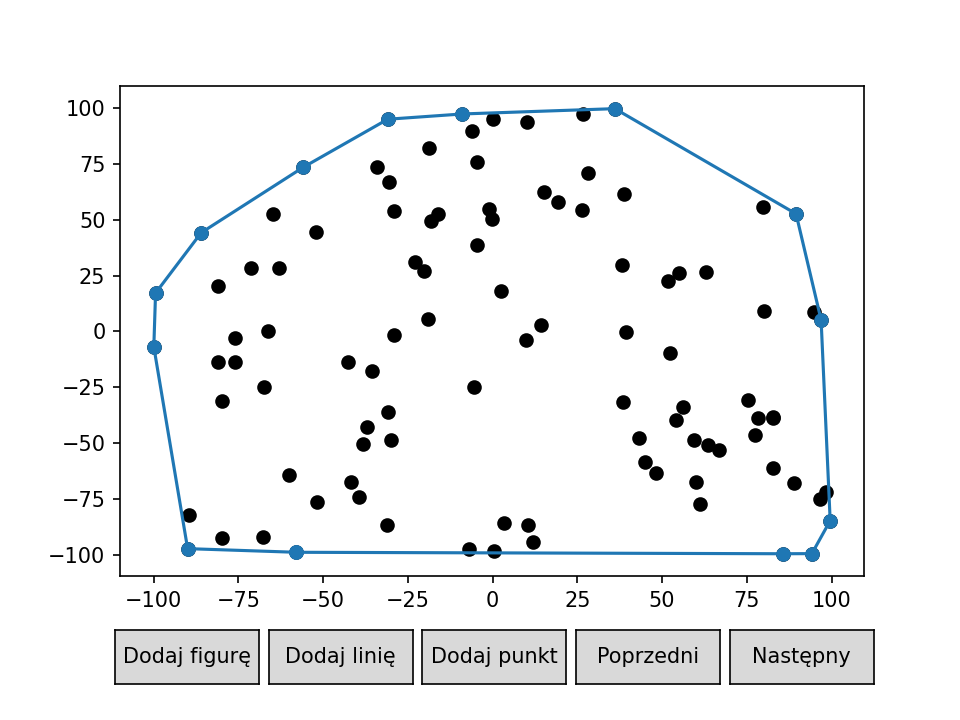

In [69]:
# Polecenia służące do rysowania wykresów
plot = Plot(scenes)
plot.draw()

# 9. Funkcje do pomiaru czasu

Po niżej znajduje się impolementacja algorytmu Jarvisa i Grahama nie generująca wykresów. 
Taka wersja pozwala analizować prędkość obu algorytmów pomijając czas potrzebny na tworzenie scen wykresów.

9.1 Algorytm Grahama

In [45]:
def graham_fast(tab, epsilon):    
    points = tab.copy()
    p0 = find_lowest(points)
    mergeSort(points, p0, epsilon)
    points = remove_col(points, p0, epsilon) 
    res = [p0, points[0], points[1]]
   
    i = 2 
    while i < len(points):
        while len(res)>=2 and det(res[-2], res[-1], points[i]) < epsilon:
            res.pop()
                
        res.append(points[i])
        i +=1   
    return res

9.2 Algorytm Jarvisa

In [22]:
def jarvis_fast(tab, epsilon):  
    def find_next_angle(p1, tab, epsilon):
        def dist(p1, p2):
            return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2  # bez sqrt, by zmniejszyc blad
        res = tab[0]
        for p in tab:
            if  -epsilon < det(p1,res,p) < epsilon and dist(p1, p) > dist(res, p1) :
                res = p
            elif det(p1,res,p) < -epsilon:
                res = p
        return res
    
    points = tab.copy()
    p0 = find_lowest(points)
    res = [p0]
    points = [p0] + points
    p = None
    while p is not p0:
        p = find_next_angle(res[-1], points, epsilon)
        res.append(p)
      
    res = res [:-1]    
    return res

9.3 Funkcja wypisująca czasy wykonania się obu algorytmów

In [23]:
def time_comp(tab, epsilon):
    start_time = time.time()
    res = graham_fast(tab, epsilon)
    end_time = time.time()
    print("czas algorytmu Grahama: ", end_time - start_time)
    start_time = time.time()
    res = jarvis_fast(tab, epsilon)
    end_time = time.time()
    print("czas algorytmu Jarvisa: ", end_time - start_time)

In [24]:
time_comp(tab1, 10**(-11))

czas algorytmu Grahama:  0.0010001659393310547
czas algorytmu Jarvisa:  0.001996755599975586


# 10. Funkcja zapisująca punkty należace do otoczki wypukłej w pliku tekstowym

In [25]:
def save(res, file):
    f = open(file + ".txt","w")   
    for i in res: 
        f.write(str(i)+'\n') 
    f.close()

In [67]:
save(graham_fast2(tab1,10**(-10)), "plik") # Zaleca się używania wersji *_fast algorytmów - Generuje ona tylko zbiory punktów

# 11. Algorytm Grahama pomijający usuwanie punktów o tym samym kącie

In [37]:
def graham_fast2(tab, epsilon):    
    def dist(p1, p2):
        return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2  # bez sqrt, by zmniejszyc blad
    points = tab.copy()
    p0 = find_lowest(points)
    mergeSort(points, p0, epsilon)
    points = remove_col(points, p0, epsilon) 
    res = [p0, points[0], points[1]]
   
    i = 2 
    while i < len(points):
        d = det(res[-2], res[-1], points[i])
        while len(res)>=2 and ((d < -epsilon) or ( -epsilon <= d <= epsilon and dist(res[-2], points[i]) > dist(res[-2], res[-1]))) :
            res.pop()
            d = det(res[-2], res[-1], points[i])
                
        res.append(points[i])
        i +=1   
    return res

In [38]:
def time_comp(tab, epsilon):
    start_time = time.time()
    res = graham_fast(tab, epsilon)
    end_time = time.time()
    print("czas algorytmu Grahama z usuwaniem: ", end_time - start_time)
    start_time = time.time()
    res = graham_fast2(tab, epsilon)
    end_time = time.time()
    print("czas algorytmu Grahama bez usuwania: ", end_time - start_time)

In [43]:
time_comp(tab4, 10**(-11))

czas algorytmu Grahama z usuwaniem:  0.0
czas algorytmu Grahama bez usuwania:  0.001003265380859375
